In [2]:
library(ggplot2)
library(dplyr)
library(stringr)
library(data.table)
library(glue)
library(IRdisplay)
# install facets and facetsCH if you haven't already
library(facets)
library(facetsCH)

# Read in PON Pileups

In [2]:
# list of pileup files (from FACETS snp-pileup)
pileup_list = paste0(
    '/work/isabl/ref/homo_sapiens/GRCh37d5/facets_ch/db/pon_pileups/', 
    pon[['sample_id']], 
    '_pileup.tsv.gz'
)

pileups = lapply(pileup_list, function(file){
    fread(file)
})

# Create Het SNP Whitelist

## Calculate distribution

In [4]:
# calculate BAF
baf_pileups = lapply(pileups, function(pu) {
    pu %>% mutate(
        depth = File1R + File1A,
        baf = File1A / depth,
        valor = log2(File1A/File1R)
    ) %>%
    select(chr = Chromosome, pos = Position, depth, baf, valor) %>%
    filter(depth > 50 & depth < 2000) %>%
    filter(baf < 0.9 & baf > 0.1)
})

hets_iwg = Reduce(rbind, baf_pileups) %>% 
    mutate(chr = ifelse(chr == 'X', 23, as.integer(chr))) %>%
    mutate(snp_index = paste0(chr, '_', pos))

Warning message in ifelse(chr == "X", 23, as.integer(chr)):
“NAs introduced by coercion”


In [5]:
# calculate SNP-specific BAF distribution across samples
snp_bafs_iwg = hets_iwg %>%
    group_by(chr, pos) %>%
    summarise(
        baf_median = median(baf),
        n = n(),
        baf_sd = sd(baf),
        valor_median = median(valor),
        valor_sd = sd(valor)
    ) %>%
    ungroup() %>%
    mutate(chr = ifelse(chr == 'X', 23, as.integer(chr))) %>%
    filter(!is.na(chr)) %>%
    mutate(snp_index = paste0(chr, '_', pos))

## Diagnostic plots

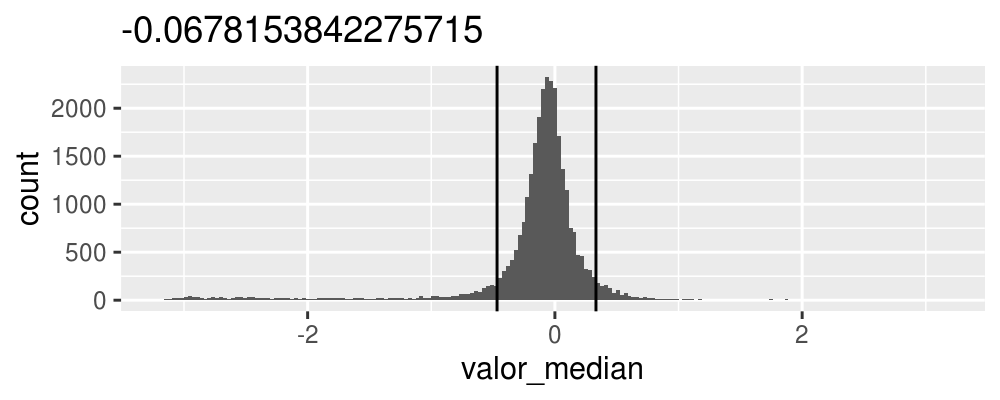

In [7]:
options(repr.plot.width = 5, repr.plot.height = 2, repr.plot.res = 200)

# visualize and chooose threshold to exclude outlier SNPs based on median BAF
ggplot(
    snp_bafs_iwg,
    aes(x = valor_median)
) +
geom_histogram(bins = 200) +
ggtitle(median(snp_bafs_iwg$valor_median)) +
geom_vline(xintercept = median(snp_bafs_iwg$valor_median) + 0.4) +
geom_vline(xintercept = median(snp_bafs_iwg$valor_median) - 0.4)

Warning message:
“Removed 9554 rows containing non-finite values (stat_bin).”


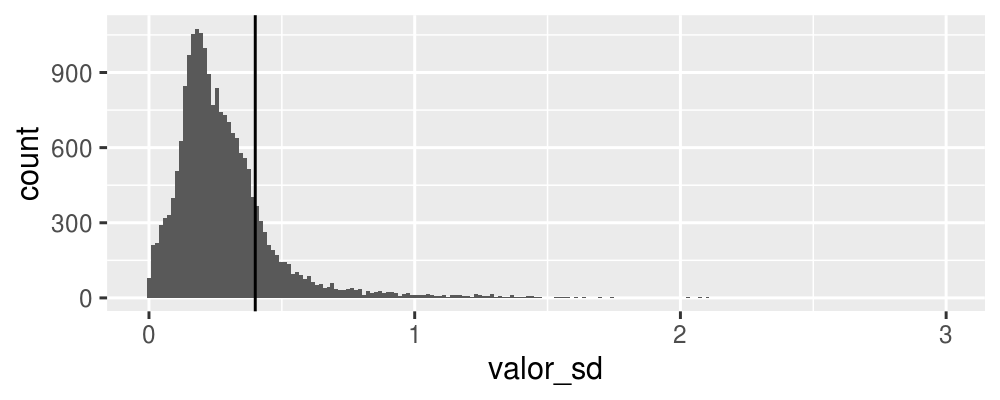

In [8]:
options(repr.plot.width = 5, repr.plot.height = 2, repr.plot.res = 200)

# visualize and chooose threshold to exclude outlier SNPs based on BAF variance
ggplot(
    snp_bafs_iwg,
    aes(x = valor_sd)
) +
geom_histogram(bins = 200) +
geom_vline(xintercept = 0.4)

In [9]:
# calculate SNP-specific coverage distribution across samples
depths_iwg = lapply(pileups, function(pu){
        pu %>% mutate(
            depth = File1R + File1A
        ) %>%
        select(chr = Chromosome, pos = Position, depth)
    }) %>%
    Reduce(rbind, .) %>%
    mutate(chr = ifelse(chr == 'X', 23, as.integer(chr))) %>%
    mutate(snp_index = paste0(chr, '_', pos))

depths_iwg = depths_iwg %>% 
    group_by(snp_index) %>%
    summarise(
        depth_median = median(depth),
        n = n()
    )

Warning message in ifelse(chr == "X", 23, as.integer(chr)):
“NAs introduced by coercion”


Warning message:
“Removed 19 rows containing non-finite values (stat_bin).”
Warning message:
“Removed 2 rows containing missing values (geom_bar).”


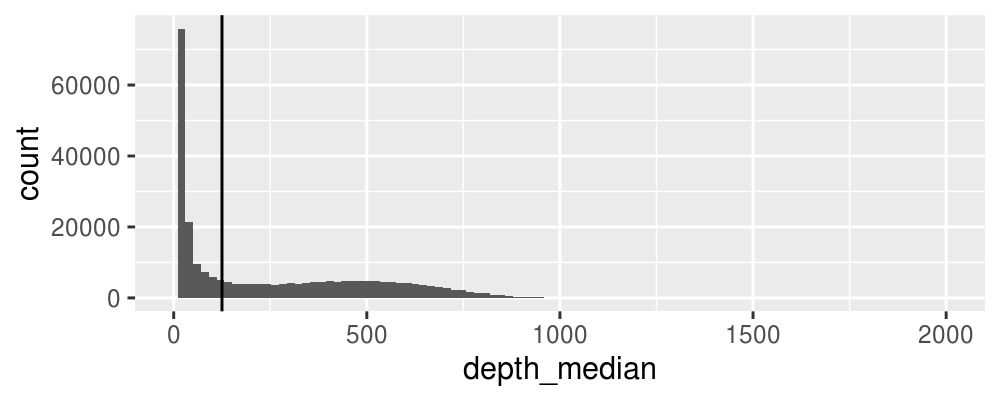

In [10]:
options(repr.plot.width = 5, repr.plot.height = 2, repr.plot.res = 200)

# visualize and chooose coverage threshold to exclude poorly covered SNPs
ggplot(
    depths_iwg,
    aes(x = depth_median)
) +
geom_histogram(bins = 100) +
xlim(0, 2000) +
geom_vline(xintercept = 125)

## Create files

In [12]:
# create hetero SNP whitelist. You may change the thresholds based on the diagnostic plots above
snp_low_cov_iwg = depths_iwg %>% filter(depth_median < 125) %>% pull(snp_index)

het_whitelist_iwg = snp_bafs_iwg %>% filter(
        valor_median < median(valor_median) + 0.4 &
        valor_median > median(valor_median) - 0.4 &
        (n == 1 | valor_sd < 0.4)
    ) %>% 
    filter(!snp_index %in% snp_low_cov_iwg) %>%
    pull(snp_index)

het_bias_iwg = hets_iwg %>%
    filter(snp_index %in% het_whitelist_iwg) %>%
    group_by(snp_index) %>%
    summarise(
        bias_mean = mean(valor),
        bias_median = median(valor),
        n = n()
    )

In [13]:
db_dir = '/work/isabl/ref/homo_sapiens/GRCh37d5/facets_ch/db'

# Write het snps whitelist
fwrite(
    list(het_whitelist_iwg), 
    glue('{db_dir}/het_whitelist_{panel}.tsv'), 
    sep = '\t'
)

# Write het snps bias
het_bias_iwg %>% 
    fwrite(
        glue('{db_dir}/het_bias_{panel}.tsv'), 
        sep = '\t'
    )

# Create SNP blacklist based on logR

## Calculate distribution

In [16]:
pon_iwg = pon

# number of females in PON
nf = 64
# number of males in PON
nm = 58
# total number of samples in PON
n = 122
# identify pairs to compare against each other
females = which(pon_iwg[['Sex']] == 'Female')[1:n]
males = which(pon_iwg[['Sex']] == 'Male')[1:n]
pairs = rbind(
    cbind(
        females[1:floor(nf/2)],
        females[(floor(nf/2) + 1):nf]
    ),
    cbind(
        males[1:floor(nm/2)],
        males[(floor(nm/2) + 1):nm]
    )
)

In [17]:
# calculate logR for each sample pair
sigs_pon = lapply(1:nm, function(i) {
    pair = pairs[i,]
    get_logr(pileups[[pair[1]]], pileups[[pair[2]]], 0, 25) %>%
    mutate(normal = i) %>%
    select(chrom, maploc, cnlr, normal)
})

sigs_pon = Reduce(rbind, sigs_pon)

sigs_pon = sigs_pon %>% mutate(snp_index = paste0(chrom, '_', maploc))

cnlrs = sigs_pon %>% 
    group_by(snp_index) %>%
    summarise(
        cnlr_mean = mean(cnlr),
        cnlr_sd = sd(cnlr),
        cnlr_n = n()
    ) %>%
    ungroup()

## Diagnostic plots

Warning message:
“Removed 7815 rows containing non-finite values (stat_bin).”
Warning message:
“Removed 2 rows containing missing values (geom_bar).”


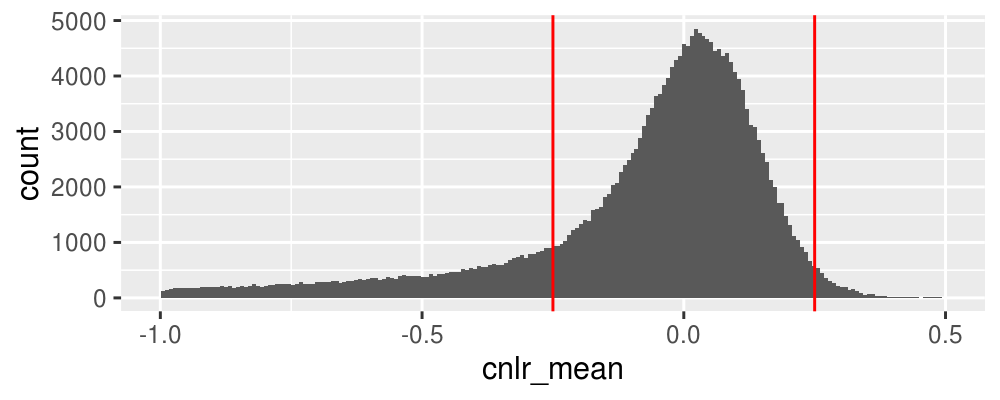

In [18]:
options(repr.plot.width = 5, repr.plot.height = 2, repr.plot.res = 200)

# visualize and choose thresolds to exclude SNPs with aberrant logR mean
ggplot(
    cnlrs,
    aes(cnlr_mean)
) +
geom_histogram(bins = 200) +
geom_vline(xintercept = -0.25, color = 'red') +
geom_vline(xintercept = 0.25, color = 'red') +
xlim(-1, 0.5)

Warning message:
“Removed 6385 rows containing non-finite values (stat_bin).”


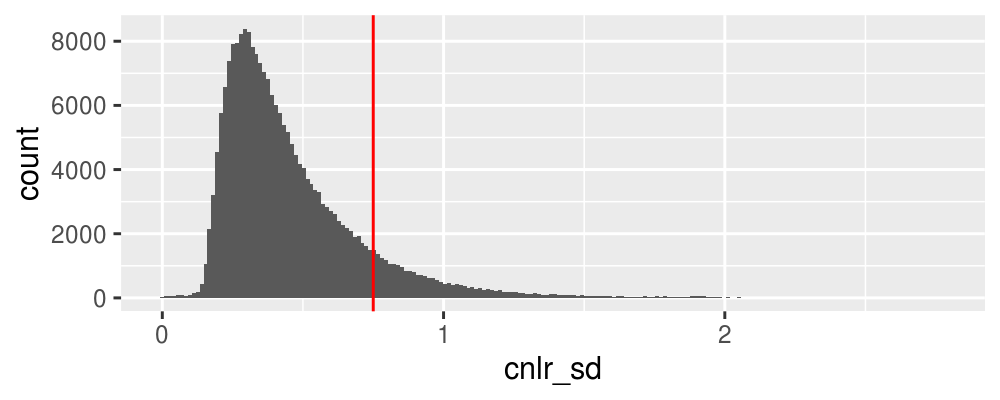

In [19]:
options(repr.plot.width = 5, repr.plot.height = 2, repr.plot.res = 200)

# visualize and choose thresolds to exclude SNPs with large logR variance
ggplot(
    cnlrs,
    aes(cnlr_sd)
) +
geom_histogram(bins = 200) +
geom_vline(xintercept = 0.75, color = 'red')

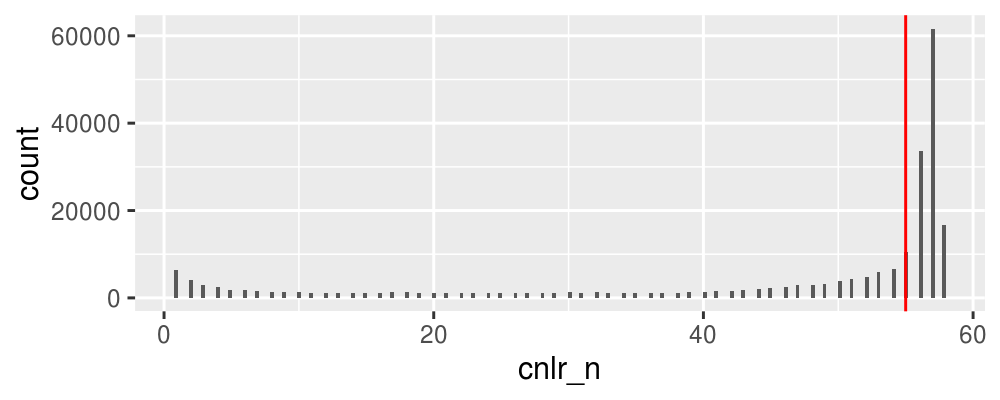

In [20]:
options(repr.plot.width = 5, repr.plot.height = 2, repr.plot.res = 200)

# visualize and choose thresolds to exclude SNPs that are not covered well
ggplot(
    cnlrs,
    aes(cnlr_n)
) +
geom_histogram(bins = 200) +
geom_vline(xintercept = 55, color = 'red')

# Create files

In [21]:
# create and write SNP blacklist to DB. You may change the thresholds based on the diagnostic plots above
snp_blacklist_iwg = cnlrs %>% 
    filter(cnlr_mean < -0.25 | cnlr_mean > 0.25 | cnlr_sd > 0.75 | (cnlr_n <= 55 & (!snp_index %in% het_whitelist_iwg))) %>% 
    pull(snp_index)

list(snp_blacklist_iwg) %>% 
    fwrite(glue('{db_dir}/snp_blacklist_{panel}.tsv'))